## Explore PFT calibration
#### GP emulators for PFT mean LAI

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm
import os
import seaborn as sns
import gpflow
import tensorflow as tf

from esem.utils import get_random_params, get_uniform_params

import warnings
warnings.filterwarnings("ignore")

2023-08-25 16:26:51.730293: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-25 16:26:52.609487: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-25 16:26:53.181634: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-25 16:26:57.189016: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("../") ; sys.path.append("../../") 
from ppe_analysis.analysis import *
from emulation_pyfunctions import *
from pyfunctions import *

In [3]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='25GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='23:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(100)

# Setup your client
client = Client(cluster)

In [5]:
client.cluster

PBSCluster(aa2af584, 'tcp://10.12.206.59:45378', workers=100, threads=100, memory=2.27 TiB)

### Load LHC CLM-PPE (PFT mean annual max LAI)

In [6]:
# CLM-PPE
dvs=['TLAI']
htape='h1'
yr0=2003
yr1=2014
ds=get_exp('transient',dvs=dvs,tape=htape,yy=(yr0,yr1))

In [7]:
t=slice(str(yr0),str(yr1))
da=ds.TLAI.sel(time=t)
la=xr.open_dataset('landarea_transient.nc').landarea_pft.sel(time=t)
amax_lai=amax(da).mean(dim='year').compute()
PPE_lai = pmean(amax_lai,la).mean(dim='time').compute()

In [8]:
#get the pft names
pfts=xr.open_dataset('/glade/campaign/asp/djk2120/PPEn11/paramfiles/OAAT0000.nc').pftname
pfts=[str(p)[2:-1].strip() for p in pfts.values][0:17]

In [9]:
# load parameter sets 
lhckey = '/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt'
df = pd.read_csv(lhckey)
lhc_params = df.drop(columns='member')
num_params = len(lhc_params.columns)

In [10]:
u_params     = ['FUN_fracfixers','KCN','a_fix','crit_dayl','d_max','fff','fstor2tran','grperc',
                'jmaxb0','jmaxb1','kcha','lmrha','lmrhd','nstem','q10_mr','soilpsi_off','sucsat_sf',
                'tpu25ratio','tpuse_sf','wc2wjb0']
pft_params   = ['froot_leaf','kmax','krmax','leaf_long','leafcn','lmr_intercept_atkin',
                'medlynslope','medlynintercept','psi50','slatop','stem_leaf','theta_cj']

In [16]:
# reorder ppe_params 
ppe_params = pd.concat([lhc_params[u_params], lhc_params[pft_params]],axis=1)
ppe_params.to_csv('ppe_params_8-25.csv', sep=',')
nparams = np.shape(ppe_params)[1]

### Load Observational Target data

In [13]:
#calculate SP LAI, by pft
dsp=xr.open_dataset('/glade/scratch/linnia/archive/LAI_SP_ctsm51d115/lnd/hist/LAI_SP_ctsm51d115.clm2.h1.2000-02-01-00000.nc')
dsp['time']=xr.cftime_range('2000',periods=12,freq='MS',calendar='noleap')
sg=xr.open_dataset('../clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc')
la=sg.landfrac*sg.area

lai_sp=amax(dsp.TLAI).sel(year=2000)
w=dsp.pfts1d_wtgcell
laig=pftgrid(lai_sp,dsp)
wg=pftgrid(w,dsp)
cf=1/(wg*la).sum(dim=['lat','lon'])
laisp=cf*(laig*wg*la).sum(dim=['lat','lon']).sel(pft=range(0,16)).compute()

### Train PFT emulators

In [14]:
# Define kernels
kernel_linear = gpflow.kernels.Linear(active_dims=range(num_params),variance=1)
kernel_matern32 = gpflow.kernels.Matern32(active_dims=range(num_params), variance=1, lengthscales = np.tile(1,32))
kernel_matern52 = gpflow.kernels.Matern52(active_dims=range(num_params),variance=1,lengthscales=np.tile(1,32))
kernel_RBF = gpflow.kernels.RBF(active_dims = range(num_params), lengthscales=np.tile(1,num_params))

# select the kernal to use
kernel = kernel_linear + kernel_matern32 + kernel_RBF

2023-08-25 16:29:34.730570: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-08-25 16:29:34.730633: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (crhtc58): /proc/driver/nvidia/version does not exist
2023-08-25 16:29:34.785303: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
`min_event_ndims` is now static for all bijectors; this property is no longer needed.
INFO:tensorflow:Assets written to: ./models/needleleaf_evergreen_temperate_tree/assets
INFO:tensorflow:Assets written to: ./models/needleleaf_evergreen_boreal_tree/assets
INFO:tensorflow:Assets written to: ./models/needleleaf_deciduous_boreal_tree/assets
INFO:tensorflow:Assets written to: ./models/broadleaf_evergreen_tropical_tree/assets
INFO:tensorflow:Assets written to: ./models/broadleaf_evergreen_temperate_tree/assets
INFO:tensorflow:Assets written to: ./models/broadleaf_deciduous_tropical_tree/assets
INFO:tensorflow:Assets written to: ./models/broadleaf_deciduous_temperate_tree/assets
INFO:tensorflow:Assets written to: ./models/broadleaf_deciduous_boreal_tree/assets
INFO:tensorflow:Assets written to: ./models/broadleaf_evergreen_shrub/assets
INFO:tensorflow:Assets written to: ./models/broadleaf_deciduous_temperate_shrub/assets
INFO:tensorflow:Assets written to: ./models

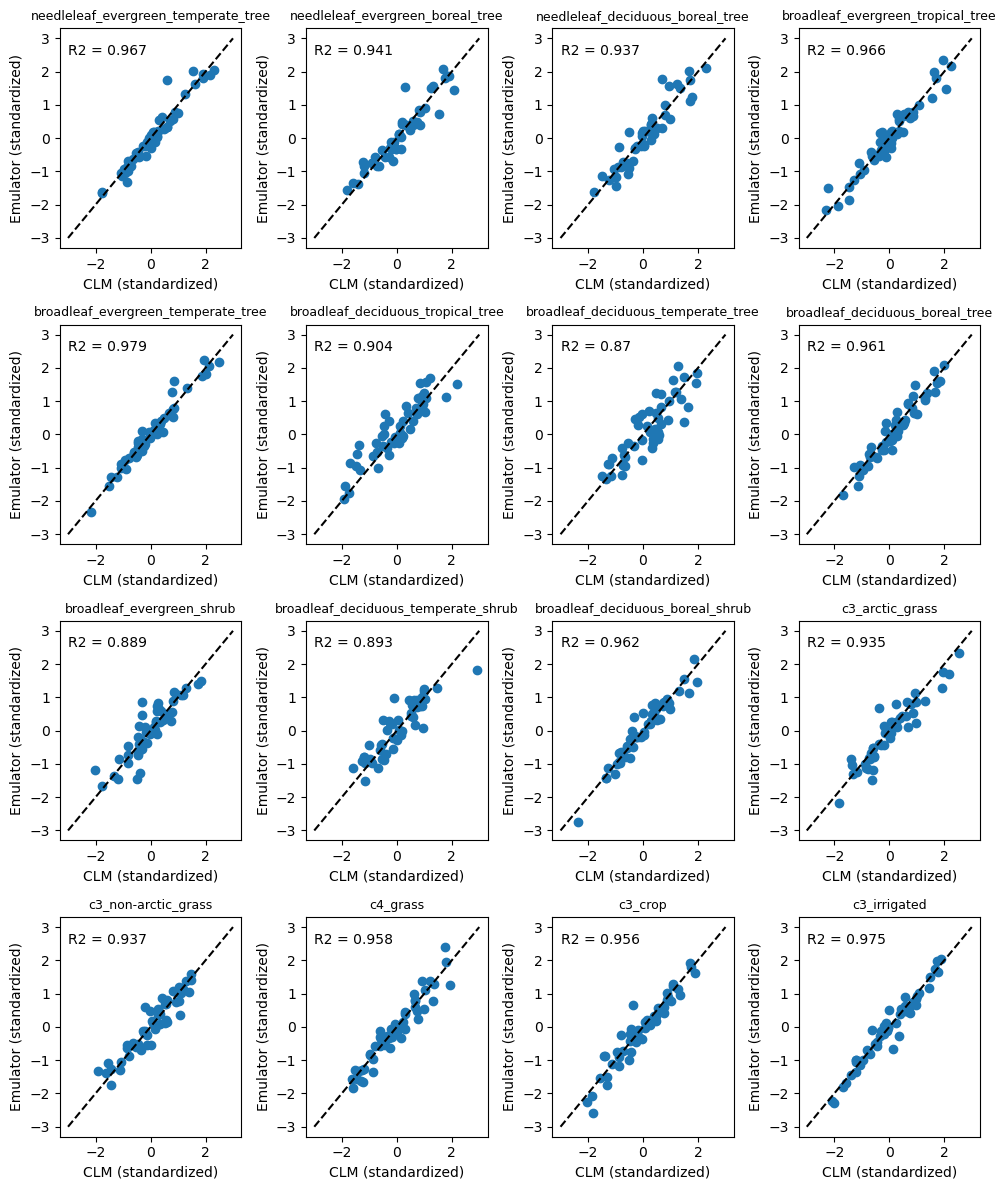

In [17]:
# train emulators (using GPFlow)
plt.figure(figsize=[10,12])
plt.rcParams.update({'font.size': 10})

PFT_emulator_dict = {}
keys = pfts

for i in range(1,17):

    y_data = PPE_lai.sel(pft=i)
    
    ax = plt.subplot(4,4,i)
    savedir = str('./models/'+keys[i])

    emulator = trainGP_GPFlow(y_data[1:],ppe_params,50,ax,kernel)
    
    emulator.compiled_predict_y = tf.function(
        lambda xnew: emulator.predict_y(xnew, full_cov=False),
        input_signature=[tf.TensorSpec(shape=[None, nparams], dtype=tf.float64)],
    )
    tf.saved_model.save(emulator, savedir)
    
    ax.set_title(pfts[i],fontsize=9)

plt.tight_layout()
plt.savefig('./figs/PFT_LAImax_emulator_validation_GPFlow.png',dpi = 100)

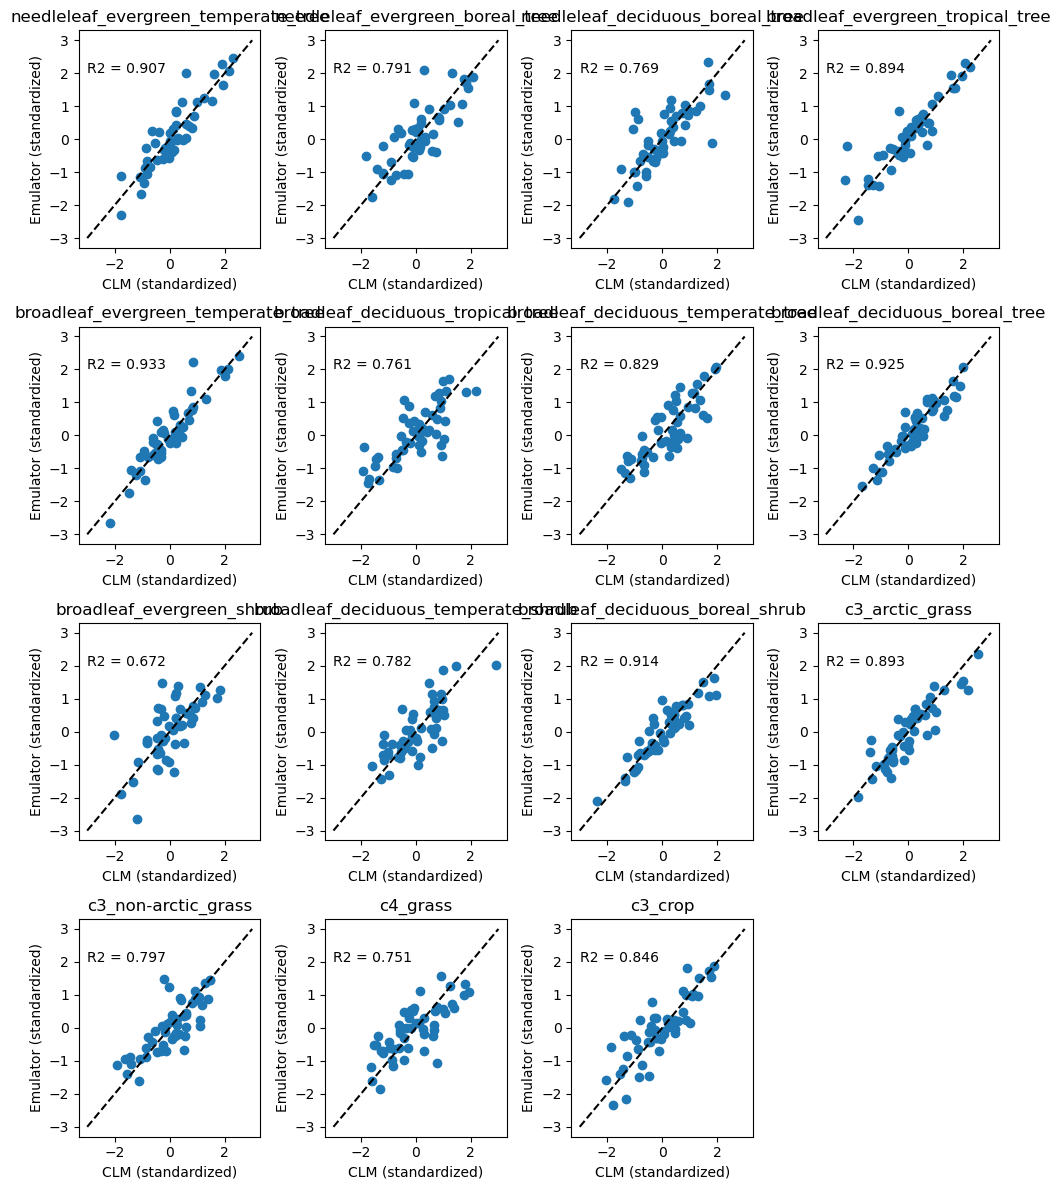

In [31]:
# ESEM train emulators and save in a dictionary 
plt.figure(figsize=[10,12])
plt.rcParams.update({'font.size': 10})

PFT_emulator_dict = {}
keys = pfts

for i in range(1,16):

    y_data = PPE_lai.sel(pft=i)
    
    ax = plt.subplot(4,4,i)

    emulator = trainGP_ESEm(y_data[1:],ppe_params,50,ax)
    
    PFT_emulator_dict[keys[i]] = emulator
    
    ax.set_title(pfts[i])

plt.tight_layout()
#plt.savefig('./figs/PFT_LAImax_emulator_validation.png',dpi = 100)

### Sample & Predict

In [18]:
#randomly sample universal parameters
np.random.seed(444)
n_usamp = 10000
u_sample = get_random_params(len(u_params), n_usamp)
np.savetxt("/glade/work/linnia/CLM-PPE-LAI_tests/exp2_pftLAI/universal_sample_8-25.txt", u_sample,delimiter=',')

In [19]:
# randomly sample PFT parameters
np.random.seed(22)
n_psamp = 1000
pft_sample = get_random_params(len(pft_params), n_psamp)
np.savetxt("/glade/work/linnia/CLM-PPE-LAI_tests/exp2_pftLAI/pft_sample_8-25.txt", pft_sample,delimiter=',')

#uniform_sample = np.arange(0,1.0,0.025)
#n_psamp = len(uniform_sample)
#pft_sample = np.reshape(uniform_sample,(40,1))

In [20]:
n_pfts = 17
n_batch = 10
batch_size = np.int(n_usamp/n_batch)

# allocate output array
PFT_pred= np.empty([n_usamp,n_psamp,n_pfts])

In [21]:
batch_size

1000

In [22]:
%%time

#loop through batches
st = 0
for i in range(n_batch):
    en = np.int(st+batch_size)
    print(en)
    
    tmp_samp = np.concatenate((np.repeat(u_sample[st:en,:],n_psamp,axis=0),np.tile(pft_sample,(batch_size,1))),axis=1)
    for j,p in enumerate(pfts[1:15]):
        loaded_emulator = tf.saved_model.load('./models/'+p)
        y_pred_std, _ = loaded_emulator.compiled_predict_y(tmp_samp) 
        y_pred = unstandardize(np.array(y_pred_std).reshape(1,-1),PPE_lai.sel(pft=j+1))
        PFT_pred[st:en,:,j+1] = np.reshape(y_pred,(batch_size,n_psamp))
    
    st = st+batch_size

1000
2000
3000
4000
5000
6000
7000
8000
9000
CPU times: user 1h 56min 56s, sys: 6min 35s, total: 2h 3min 32s
Wall time: 2h 6min 57s


In [27]:
np.save('/glade/work/linnia/CLM-PPE-LAI_tests/exp2_pftLAI/PFT_pred_8-25.npy',PFT_pred)

### Calculate metrics

In [28]:
# Calculate the fractional bias 
fbias = np.empty(np.shape(PFT_pred[:,:,:16]))
tmp = np.tile(laisp,(n_psamp,1))
for i in range(n_usamp):
    var = PFT_pred[i,:,:16]
    fbias[i,:,:] = (var-tmp)/tmp

In [29]:
np.save('/glade/work/linnia/CLM-PPE-LAI_tests/exp2_pftLAI/fractional_bias_8-25.npy',fbias)

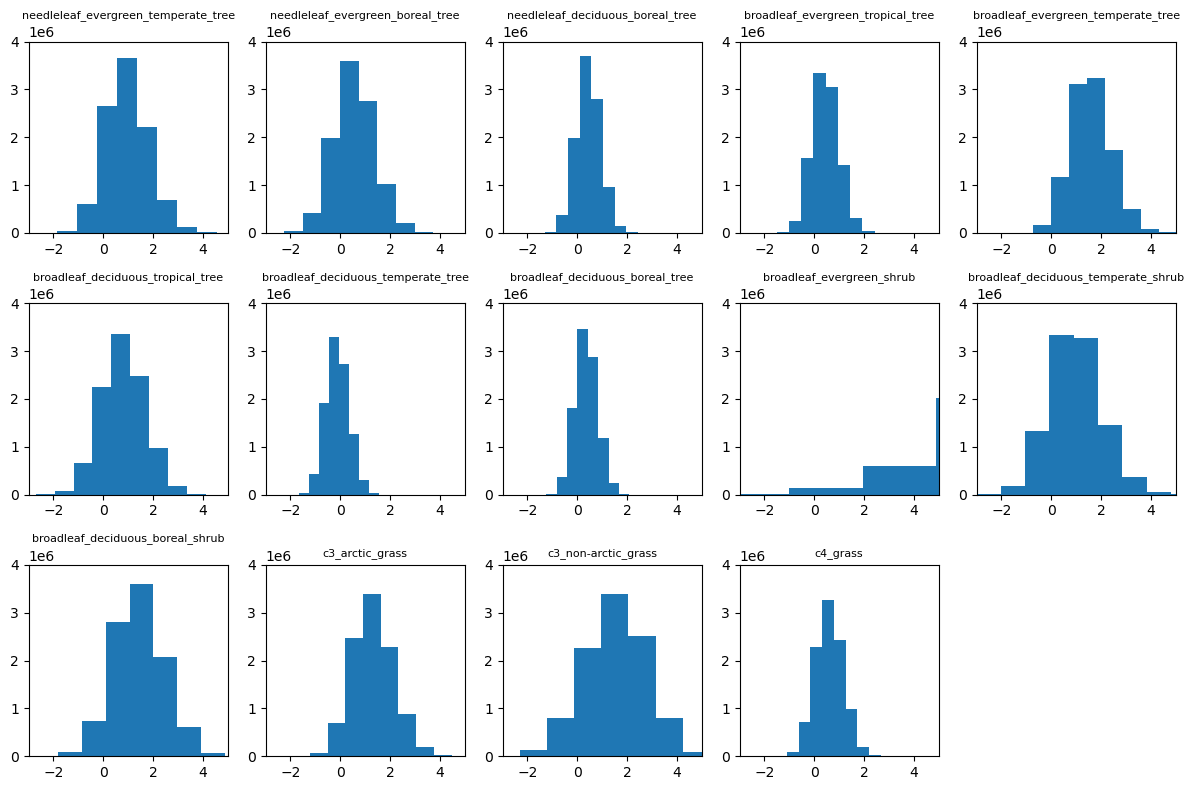

In [30]:
# plot fractional bias 
plt.figure(figsize=[12,8])
for i in range(1,15):
    plt.subplot(3,5,i)
    plt.hist(fbias[:,:,i].flatten())
    plt.title(pfts[i],fontsize=8)
    plt.xlim([-3,5])
    plt.ylim([0,4000000])
    
plt.tight_layout()
plt.savefig('./figs/fbias_hist_8-25.png',dpi=100)

### Repeat for GPP

In [31]:
# CLM-PPE
dvs=['GPP']
htape='h1'
yr0=2007
yr1=2013
ds=get_exp('transient',dvs=dvs,tape=htape,yy=(yr0,yr1))

In [32]:
t=slice(str(yr0),str(yr1))
da=ds.GPP.sel(time=t)
la=xr.open_dataset('landarea_transient.nc').landarea_pft.sel(time=t)
amean_gpp=amean(da).mean(dim='year').compute()
PPE_gpp = pmean(amean_gpp,la).mean(dim='time').compute()

#### Train GPP emulators

In [33]:
# Define kernels
kernel_linear = gpflow.kernels.Linear(active_dims=range(num_params),variance=1)
kernel_matern32 = gpflow.kernels.Matern32(active_dims=range(num_params), variance=1, lengthscales = np.tile(1,32))
kernel_matern52 = gpflow.kernels.Matern52(active_dims=range(num_params),variance=1,lengthscales=np.tile(1,32))
kernel_RBF = gpflow.kernels.RBF(active_dims = range(num_params), lengthscales=np.tile(1,num_params))

# select the kernal to use
kernel = kernel_linear + kernel_matern32 + kernel_RBF

INFO:tensorflow:Assets written to: ./models_gpp/needleleaf_evergreen_temperate_tree/assets
INFO:tensorflow:Assets written to: ./models_gpp/needleleaf_evergreen_boreal_tree/assets
INFO:tensorflow:Assets written to: ./models_gpp/needleleaf_deciduous_boreal_tree/assets
INFO:tensorflow:Assets written to: ./models_gpp/broadleaf_evergreen_tropical_tree/assets
INFO:tensorflow:Assets written to: ./models_gpp/broadleaf_evergreen_temperate_tree/assets
INFO:tensorflow:Assets written to: ./models_gpp/broadleaf_deciduous_tropical_tree/assets
INFO:tensorflow:Assets written to: ./models_gpp/broadleaf_deciduous_temperate_tree/assets
INFO:tensorflow:Assets written to: ./models_gpp/broadleaf_deciduous_boreal_tree/assets
INFO:tensorflow:Assets written to: ./models_gpp/broadleaf_evergreen_shrub/assets
INFO:tensorflow:Assets written to: ./models_gpp/broadleaf_deciduous_temperate_shrub/assets
INFO:tensorflow:Assets written to: ./models_gpp/broadleaf_deciduous_boreal_shrub/assets
INFO:tensorflow:Assets writt

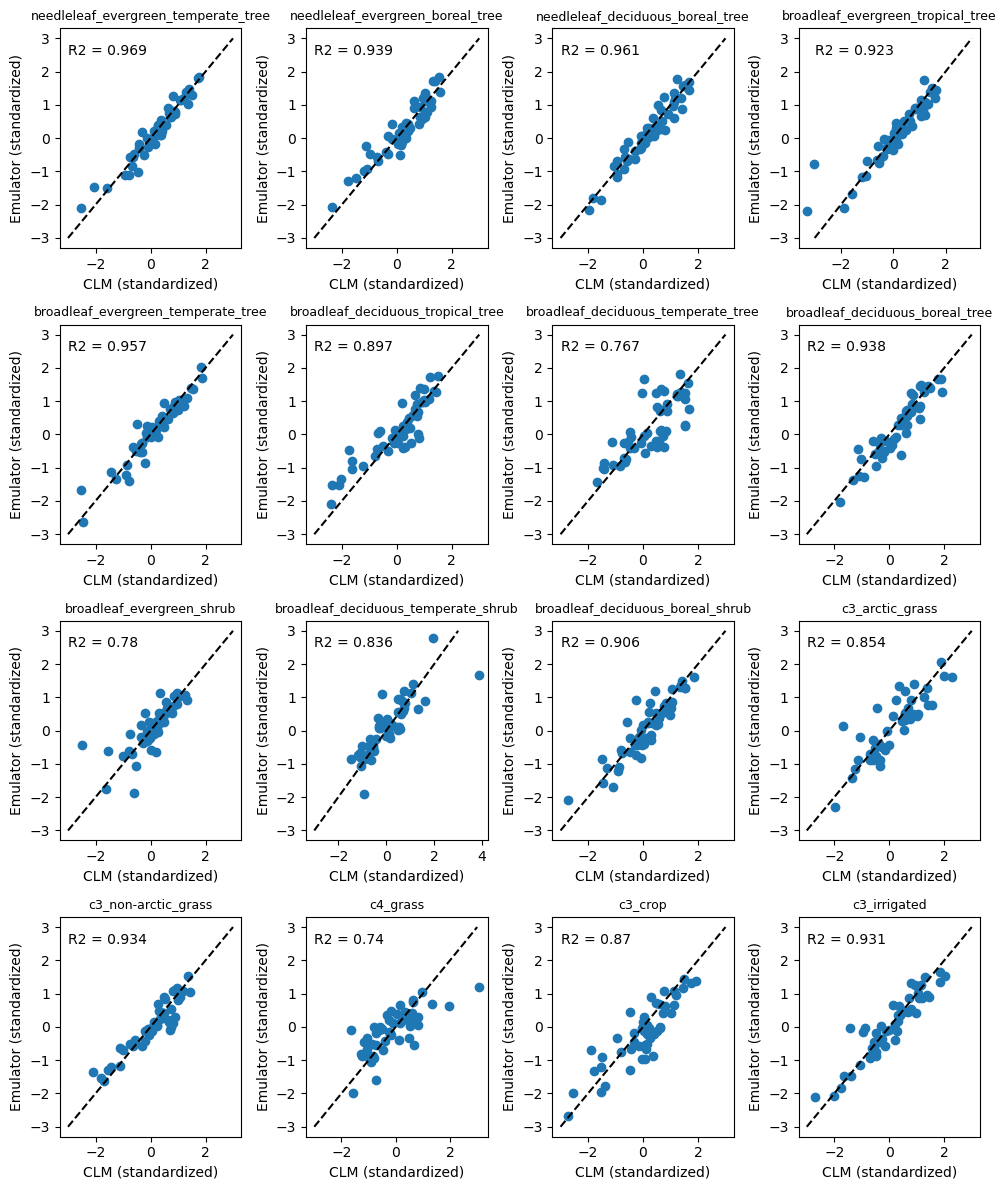

In [34]:
# train emulators (using GPFlow)

plt.figure(figsize=[10,12])
plt.rcParams.update({'font.size': 10})

for i in range(1,17):

    y_data = PPE_gpp.sel(pft=i)
    
    ax = plt.subplot(4,4,i)
    savedir = str('./models_gpp/'+pfts[i])

    emulator = trainGP_GPFlow(y_data[1:],ppe_params,50,ax,kernel)
    
    emulator.compiled_predict_y = tf.function(
        lambda xnew: emulator.predict_y(xnew, full_cov=False),
        input_signature=[tf.TensorSpec(shape=[None, nparams], dtype=tf.float64)],
    )
    tf.saved_model.save(emulator, savedir)
    
    ax.set_title(pfts[i],fontsize=9)

plt.tight_layout()
plt.savefig('./figs/PFT_GPPmean_emulator_validation_GPflow.png',dpi = 100)

In [35]:
%%time
# allocate output array
PFT_pred_gpp = np.empty([n_usamp,n_psamp,n_pfts])

#loop through batches
st = 0
for i in range(n_batch):
    en = np.int(st+batch_size)
    print(en)
    
    tmp_samp = np.concatenate((np.repeat(u_sample[st:en,:],n_psamp,axis=0),np.tile(pft_sample,(batch_size,1))),axis=1)
    for j,p in enumerate(pfts[1:15]):
        loaded_emulator = tf.saved_model.load('./models_gpp/'+p)
        y_pred_std, _ = loaded_emulator.compiled_predict_y(tmp_samp) 
        y_pred = unstandardize(np.array(y_pred_std).reshape(1,-1),PPE_gpp.sel(pft=j+1))
        PFT_pred_gpp[st:en,:,j+1] = np.reshape(y_pred,(batch_size,n_psamp))
    
    st = st+batch_size

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
CPU times: user 1h 54min 51s, sys: 7min 2s, total: 2h 1min 53s
Wall time: 2h 6min 35s


In [37]:
np.save('/glade/work/linnia/CLM-PPE-LAI_tests/exp2_pftLAI/PFT_pred_GPP_8-25.npy',PFT_pred_gpp)